In [0]:
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import clear_output

#### [TensorFlow Datasets](https://www.tensorflow.org/datasets) 

[Introducing TensorFlow Datasets](https://medium.com/tensorflow/introducing-tensorflow-datasets-c7f01f7e19f3)

可用于 TensorFlow 的一系列数据集的集合。所有数据集都显示为 **tf.data.Datasets**，可以提供易于使用且具有高性能的输入流水线。

安装：pip install tensorflow-datasets

- tfds.list_builders():查看可用的数据集
- tfds.load(name = "dataset_name",split = "trian"):加载所选的数据集，并按train的方式自动进行划分

所有tfds数据集都包含将特征名映射到张量值的特征字典。一个典型的数据集，比如MNIST，有两个键:“image”和“label”。

- 使用DatasetBuilder完成数据集的加载


```python
mnist_builder = tfds.builder("mnist")
mnist_builder.download_and_prepare()
mnist_train = mnist_builder.as_dataset(split="train")
mnist_train
```

- 构建输入流水线


```python
mnist_train = mnist_train.repeat().shuffle(1024).batch(32)

# prefetch will enable the input pipeline to asynchronously fetch batches while
# your model is training.
mnist_train = mnist_train.prefetch(tf.data.experimental.AUTOTUNE)

# Now you could loop over batches of the dataset and train
# for batch in mnist_train:
#   ...
```

- 查看数据集的相关信息：

```python
info = minst_builder.info
info

print (info.features)
print (info.features["label"].num_classes)
print (info.features["label"].names)
```




In [0]:
!pip install tensorflow-gpu==2.0.0-beta0
clear_output()

import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2.0.0-beta0


In [0]:
import logging
# 使用logging模块来获取训练过程中的一些信息
logging.basicConfig(level=logging.ERROR)
# 不使用科学计数法
np.set_printoptions(suppress=True)

In [0]:
# 显式制定使用GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# 配置实验中所需的文件路径
output_dir = "nmt"
en_vocab_file = os.path.join(output_dir, "en_vocab")
zh_vocab_file = os.path.join(output_dir, "zh_vocab")
checkpoint_path = os.path.join(output_dir, "checkpoints")
log_dir = os.path.join(output_dir, 'logs')
download_dir = "tensorflow-datasets/downloads"

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

### 输入流水线

Transformer相比较于RNNs一个优点就在于并行化，因此为了充分利用这个优势，我们需要构建输入Input pipeline。它可以实现在当前训练步骤完成之前就准备好下一时刻所需的数据，这里需要使用**tf.data**这个API。

In [0]:
# 使用tfds.builder查看可使用的中英互翻数据集
tmp_builder = tfds.builder("wmt19_translate/zh-en")
pprint(tmp_builder.subsets)

{NamedSplit('train'): ['newscommentary_v14',
                       'wikititles_v1',
                       'uncorpus_v1',
                       'casia2015',
                       'casict2011',
                       'casict2015',
                       'datum2015',
                       'datum2017',
                       'neu2017'],
 NamedSplit('validation'): ['newstest2018']}


这里主要使用到**tfds.translate**和**tfds.builder**这两个API，它们可以完成如下的一些工作：

- 下载语料库的压缩文件并自动解压缩
- 逐行读取CSV文件里所有的中英语句，并将不符合格式要求的剔除
- 打乱语料库并将其转换为TFRecoder格式的数据方便加速读取

In [0]:
# 配置文件：选择newscommentary_v14作为所用的语料库
config = tfds.translate.wmt.WmtConfig(
  version=tfds.core.Version('0.0.3', experiments={tfds.core.Experiment.S3: False}),
  language_pair=("zh", "en"),
  subsets={
    tfds.Split.TRAIN: ["newscommentary_v14"]
  }
)

builder = tfds.builder("wmt_translate", config=config)
builder.download_and_prepare(download_dir=download_dir)
clear_output()

#### 划分语料库

20%用来训练，1%用于验证，其余的舍弃不用。这样的划分只是为了方便快速的验证模型，如果想效果更好可使用更多的数据进行训练。

In [0]:
# 划分语料库
train_perc = 20
val_prec = 1
drop_prec = 100 - train_perc - val_prec

split = tfds.Split.TRAIN.subsplit([train_perc, val_prec, drop_prec])
split

(NamedSplit('train')(tfds.percent[0:20]),
 NamedSplit('train')(tfds.percent[20:21]),
 NamedSplit('train')(tfds.percent[21:100]))

In [0]:
# train_expamples和val_examples都是_OptionsDataset，其中包含中英文配对的字符串形式的数据
examples = builder.as_dataset(split=split, as_supervised=True)
train_examples, val_examples, _ = examples

print(train_examples)
print(val_examples)

<_OptionsDataset shapes: ((), ()), types: (tf.string, tf.string)>
<_OptionsDataset shapes: ((), ()), types: (tf.string, tf.string)>


In [0]:
# 数据都以tf.Tensor的形式存在
for en, zh in train_examples.take(3):
  print(en)
  print(zh)
  # print (zh.numpy())
  print('-' * 10)

tf.Tensor(b'Making Do With More', shape=(), dtype=string)
tf.Tensor(b'\xe5\xa4\x9a\xe5\x8a\xb3\xe5\xba\x94\xe5\xa4\x9a\xe5\xbe\x97', shape=(), dtype=string)
b'\xe5\xa4\x9a\xe5\x8a\xb3\xe5\xba\x94\xe5\xa4\x9a\xe5\xbe\x97'
----------
tf.Tensor(b'If the Putins, Erdo\xc4\x9fans, and Orb\xc3\xa1ns of the world want to continue to benefit economically from the open international system, they cannot simply make up their own rules.', shape=(), dtype=string)
tf.Tensor(b'\xe5\xa6\x82\xe6\x9e\x9c\xe6\x99\xae\xe4\xba\xac\xe3\x80\x81\xe5\x9f\x83\xe5\xb0\x94\xe5\xa4\x9a\xe5\xae\x89\xe5\x92\x8c\xe6\xac\xa7\xe5\xb0\x94\xe7\x8f\xad\xe5\xb8\x8c\xe6\x9c\x9b\xe7\xbb\xa7\xe7\xbb\xad\xe4\xba\xab\xe6\x9c\x89\xe5\xbc\x80\xe6\x94\xbe\xe5\x9b\xbd\xe9\x99\x85\xe4\xbd\x93\xe7\xb3\xbb\xe6\x8f\x90\xe4\xbe\x9b\xe7\x9a\x84\xe7\xbb\x8f\xe6\xb5\x8e\xe5\x88\xa9\xe7\x9b\x8a\xef\xbc\x8c\xe5\xb0\xb1\xe4\xb8\x8d\xe8\x83\xbd\xe7\xae\x80\xe5\x8d\x95\xe5\x9c\xb0\xe5\x88\xb6\xe5\xae\x9a\xe8\x87\xaa\xe5\xb7\xb1\xe7\x9a\x84\xe8\x

In [0]:
sample_examples = []
num_samples = 3

for en_t, zh_t in train_examples.take(num_samples):
  # 使用numpy()方法得到张量的内容后按utf-8的编码格式进行解码
  en = en_t.numpy().decode("utf-8")
  zh = zh_t.numpy().decode("utf-8")
  
  print(en)
  print(zh)
  print('-' * 10)
  
  # 用于简单评估模型的训练
  sample_examples.append((en, zh))
  print (sample_examples)

Making Do With More
多劳应多得
----------
[('Making Do With More', '多劳应多得')]
If the Putins, Erdoğans, and Orbáns of the world want to continue to benefit economically from the open international system, they cannot simply make up their own rules.
如果普京、埃尔多安和欧尔班希望继续享有开放国际体系提供的经济利益，就不能简单地制定自己的规则。
----------
[('Making Do With More', '多劳应多得'), ('If the Putins, Erdoğans, and Orbáns of the world want to continue to benefit economically from the open international system, they cannot simply make up their own rules.', '如果普京、埃尔多安和欧尔班希望继续享有开放国际体系提供的经济利益，就不能简单地制定自己的规则。')]
This ceiling can be raised only in a deep depression or other exceptional circumstances, allowing for counter-cyclical policy so long as it is agreed that the additional deficit is cyclical, rather than structural.
只有在发生深度萧条或其他反常事件时，这一上限才能做出调整，以便让反周期政策实施足够的长度，使人们一致认为增加的赤字是周期性的，而不是结构性的。
----------
[('Making Do With More', '多劳应多得'), ('If the Putins, Erdoğans, and Orbáns of the world want to continue to benefit economically from the open

#### 建立中英文语料对应的词典

这里主要使用**tfds.features.text.SubwordTextEncoder**这个API[鼠标悬浮在函数名上可查看函数定义和参数形式]，它可以自动的读取语料库并构建词典。

In [0]:
%%time
try:
  subword_encoder_en = tfds.features.text.SubwordTextEncoder.load_from_file(en_vocab_file)
  print('Loading vocabulary from: {}'.format(en_vocab_file))
except:
  print('Building a vocabulary from scratch!')
  # 这里需要将Tensor转换为numpy数组的形式
  subword_encoder_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
      (en.numpy() for en, _ in train_examples), 
      target_vocab_size=2**13) # 大小可调
  
  # 存储创建的字典
  subword_encoder_en.save_to_file(en_vocab_file)
  

print('Vocabulary size is {}'.format(subword_encoder_en.vocab_size))
print('The first ten subwords are {}'.format(subword_encoder_en.subwords[:10]))
print()

Loading vocabulary form: nmt/en_vocab
Vocabulary size is 8135
The first ten subwords are [', ', 'the_', 'of_', 'to_', 'and_', 's_', 'in_', 'a_', 'that_', 'is_']

CPU times: user 46.7 ms, sys: 4.86 ms, total: 51.6 ms
Wall time: 54.6 ms


In [0]:
# 使用Enocder的encode方法可将输入语句根据词汇表表示为索引序列的形式
sample_string = 'China is beautiful.'
indices = subword_encoder_en.encode(sample_string)
indices

[102, 10, 2942, 7457, 1163, 7925]

In [0]:
# 查看索引和子词之间的对应关系
# 当遇到OOV时，tokenizer会将其拆分多个子词，如输出中的 beiutiful
print("{0:10}{1:6}".format("Index", "Subword"))
print("-" * 15)
for idx in indices:
  subword = subword_encoder_en.decode([idx])
  print('{0:5}{1:6}'.format(idx, ' ' * 5 + subword))

Index     Subword
---------------
  102     China 
   10     is 
 2942     bea
 7457     uti
 1163     ful
 7925     .


In [0]:
# 同样可以使用Encoder的decode方法对索引序列根据词典进行解码输出
sample_string = 'China is beautiful.'
indices = subword_encoder_en.encode(sample_string)

decoded_string = subword_encoder_en.decode(indices)
assert decoded_string == sample_string

pprint((sample_string, decoded_string))

('China is beautiful.', 'China is beautiful.')


In [0]:
# 为中文语料库建立词典
%%time
try:
  subword_encoder_zh = tfds.features.text.SubwordTextEncoder.load_from_file(zh_vocab_file)
  print('Loading vocabulary form: {}'.format(zh_vocab_file))
except:
  print('Building a vocabulary from scratch!')
  subword_encoder_zh = tfds.features.text.SubwordTextEncoder.build_from_corpus(
      (zh.numpy() for _, zh in train_examples), 
      target_vocab_size=2**13, 
      max_subword_length=1) # 中文不同于英文，词典中的每一个token是一个字
  
  subword_encoder_zh.save_to_file(zh_vocab_file)

print('Vocabulary size is {}'.format(subword_encoder_zh.vocab_size))
print('The first ten subwords are {}'.format(subword_encoder_zh.subwords[:10]))
print()

Loading vocabulary form: nmt/zh_vocab
Vocabulary size is 4201
The first ten subwords are ['的', '，', '。', '国', '在', '是', '一', '和', '不', '这']

CPU times: user 29.4 ms, sys: 4.2 ms, total: 33.6 ms
Wall time: 34.9 ms


In [0]:
# sample_examples中包含(('zh_sent','en_sent'),...)形式的数据
sample_string = sample_examples[0][1]
indices = subword_encoder_zh.encode(sample_string)
print(sample_string)
print(indices)

多劳应多得
[48, 557, 116, 48, 81]


In [0]:
en = "The eurozone’s collapse forces a major realignment of European politics."
zh = "欧元区的瓦解强迫欧洲政治进行一次重大改组。"

# 將文字转换为subword索引序列的形式
en_indices = subword_encoder_en.encode(en)
zh_indices = subword_encoder_zh.encode(zh)

print("[英中原文]（转换前）")
print(en)
print(zh)
print()
print('-' * 20)
print()
print("[英中序列]（转换后）")
print(en_indices)
print(zh_indices)

[英中原文]（转换前）
The eurozone’s collapse forces a major realignment of European politics.
欧元区的瓦解强迫欧洲政治进行一次重大改组。

--------------------

[英中序列]（转换后）
[17, 965, 11, 6, 1707, 676, 8, 211, 2712, 6683, 249, 3, 85, 1447, 7925]
[45, 206, 171, 1, 847, 197, 236, 604, 45, 90, 17, 130, 102, 36, 7, 284, 80, 18, 212, 265, 3]


#### 数据预处理

为了后续的模型训练，通常在处理文本数据时会在句首加\< start \>，句尾加\< end \>,它们在词典中对应的索引分别用**vocab_size**和**vocab_size + 1**表示。为了将它们和对应的索引加入词典，这里需要重写一下encode方法。

In [0]:
def encode(en_t, zh_t):
  # 因为无法直接操作Tensor，这里同样需要使用numpy()得到Tensor的内容再编码
  en_indices = [subword_encoder_en.vocab_size] + subword_encoder_en.encode(
      en_t.numpy()) + [subword_encoder_en.vocab_size + 1]

  zh_indices = [subword_encoder_zh.vocab_size] + subword_encoder_zh.encode(
      zh_t.numpy()) + [subword_encoder_zh.vocab_size + 1]
  # 最后返回的就是加入<start>和<end>的索引序列
  return en_indices, zh_indices

In [0]:
# train_examples为_OptionsDataset形式，所以可以使用iter()将其转换为可迭代对象，并使用next()方法获取数据
en_t, zh_t = next(iter(train_examples))
en_indices, zh_indices = encode(en_t, zh_t)

print('英文 BOS 的 index：', subword_encoder_en.vocab_size)
print('英文 EOS 的 index：', subword_encoder_en.vocab_size + 1)
print('中文 BOS 的 index：', subword_encoder_zh.vocab_size)
print('中文 EOS 的 index：', subword_encoder_zh.vocab_size + 1)

print('\n输入为 2 个 Tensors：')
pprint((en_t, zh_t))
print ()

# 我们可以看到输出的索引序列前后已经成功加上了BOS和EOS的索引
print('输出为 2 个索引序列：')
pprint((en_indices, zh_indices))

英文 BOS 的 index： 8135
英文 EOS 的 index： 8136
中文 BOS 的 index： 4201
中文 EOS 的 index： 4202

输入为 2 个 Tensors：
(<tf.Tensor: id=13894145, shape=(), dtype=string, numpy=b'Making Do With More'>,
 <tf.Tensor: id=13894146, shape=(), dtype=string, numpy=b'\xe5\xa4\x9a\xe5\x8a\xb3\xe5\xba\x94\xe5\xa4\x9a\xe5\xbe\x97'>)

输出为 2 个索引序列：
([8135, 4682, 19, 717, 7911, 298, 2701, 7980, 8136],
 [4201, 48, 557, 116, 48, 81, 4202])


#### NOTE 

因为tf.data.Dataset.map()需要在动态计算图下执行，而语料库中的数据为Tensor，而不是动态计算图下的eager Tensor。因此，如果我们想使用上面的encode()来为语料库中所有的数据编码再添加BOS和EOS的索引，需要使用tf.py_function()将其包装为eager Tensor的形式。


#### tf.py_funciton(func,inp,Tout,name = None)

功能：包装一个普通的 Python 函数，这个函数接受 numpy 的数组作为输入和输出，让这个函数可以作为 TensorFlow 计算图上的计算节点 OP 来使用。

- func: 一个 Python 函数, 它接受 NumPy 数组作为输入和输出，并且数组的类型和大小必须和输入和输出用来衔接的 Tensor 大小和数据类型相匹配
- inp: 输入的 Tensor 列表
- Tout: 输出 Tensor 数据类型的列表或元组

In [0]:
def tf_encode(en_t, zh_t):
  return tf.py_function(encode, [en_t, zh_t], [tf.int64, tf.int64])

# 使用包装后的tf_encode方法进行语料库的处理
tmp_dataset = train_examples.map(tf_encode)
en_indices, zh_indices = next(iter(tmp_dataset))
print(en_indices)
print(zh_indices)

tf.Tensor([8135 4682   19  717 7911  298 2701 7980 8136], shape=(9,), dtype=int64)
tf.Tensor([4201   48  557  116   48   81 4202], shape=(7,), dtype=int64)


In [0]:
# 丢弃掉长度超过40个token的序列
MAX_LENGTH = 40

# 布尔函数，只有对应的中英文序列长度都小于40时才回传真值
def filter_max_length(en, zh, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(en) <= max_length, tf.size(zh) <= max_length)

# tf.data.Dataset.filter(func) 只回传func为真的例子
tmp_dataset = tmp_dataset.filter(filter_max_length)

In [0]:
num_examples = 0

for en_indices, zh_indices in tmp_dataset:
  cond1 = len(en_indices) <= MAX_LENGTH
  cond2 = len(zh_indices) <= MAX_LENGTH
  assert cond1 and cond2
  num_examples += 1

print(f"语料库中共有 {num_examples} 笔数据")

语料库中共有 29914 笔数据


In [0]:
# 为了方便后续批数据的划分，这里需将所有的数据补齐
BATCH_SIZE = 64

# 补齐到语料库中例子的最大长度
tmp_dataset = tmp_dataset.padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))

en_batch, zh_batch = next(iter(tmp_dataset))
# 英文数据每个batch有64笔数据，长度都为34
print("英文索引序列的 batch")
print(en_batch)
print('-' * 20)
# 中文数据每个batch中数据的最大长度为40
print("中文索引序列的 batch")
print(zh_batch)

英文索引序列的 batch
tf.Tensor(
[[8135 4682   19 ...    0    0    0]
 [8135   17  965 ... 8136    0    0]
 [8135 6602    2 ...    0    0    0]
 ...
 [8135 1097  270 ...    0    0    0]
 [8135 1713   70 ...    0    0    0]
 [8135 2731 4553 ...    0    0    0]], shape=(64, 34), dtype=int64)
--------------------
中文索引序列的 batch
tf.Tensor(
[[4201   48  557 ...    0    0    0]
 [4201   45  206 ...    0    0    0]
 [4201   58    5 ...  683    3 4202]
 ...
 [4201   29  120 ...    0    0    0]
 [4201  297  161 ...    0    0    0]
 [4201  279  149 ... 4202    0    0]], shape=(64, 40), dtype=int64)


In [0]:
# 正式划分训练集合验证集
MAX_LENGTH = 40
BATCH_SIZE = 128
BUFFER_SIZE = 15000

# 训练集
train_dataset = (train_examples 
                 .map(tf_encode) # 输出：(英文索引序列, 中文索引序列)
                 .filter(filter_max_length) # 同上，且序列长度都不超过 40
                 .cache() # 加快读取
                 .shuffle(BUFFER_SIZE) # 打乱数据保证随机选取
                 .padded_batch(BATCH_SIZE,padded_shapes=([-1], [-1]))# 补齐
                 .prefetch(tf.data.experimental.AUTOTUNE)) # 加速
# 验证集
val_dataset = (val_examples
               .map(tf_encode)
               .filter(filter_max_length)
               .padded_batch(BATCH_SIZE,padded_shapes=([-1], [-1])))

In [0]:
# 查看批数据，shape = 2 * (batch_size,seq_len)
en_batch, zh_batch = next(iter(train_dataset))
print("英文索引序列的 batch")
print(en_batch)
print('-' * 20)
print("中文索引序列的 batch")
print(zh_batch)

英文索引序列的 batch
tf.Tensor(
[[8135  144  270 ...    0    0    0]
 [8135   39   70 ...    0    0    0]
 [8135  125 5403 ...    0    0    0]
 ...
 [8135   39    2 ...    0    0    0]
 [8135   45   82 ...    0    0    0]
 [8135   17 5723 ...    0    0    0]], shape=(128, 38), dtype=int64)
--------------------
中文索引序列的 batch
tf.Tensor(
[[4201   24  120 ...    0    0    0]
 [4201   35   51 ...    0    0    0]
 [4201   75   46 ...    0    0    0]
 ...
 [4201   35  364 ...    0    0    0]
 [4201  241   48 ...    0    0    0]
 [4201  692  179 ...    0    0    0]], shape=(128, 40), dtype=int64)


In [0]:
demo_examples = [
    ("It is important.", "这很重要。"),
    ("The numbers speak for themselves.", "数字证明了一切。"),
]
pprint(demo_examples)

[('It is important.', '这很重要。'),
 ('The numbers speak for themselves.', '数字证明了一切。')]


In [0]:
batch_size = 2
demo_examples = tf.data.Dataset.from_tensor_slices((
    [en for en, _ in demo_examples], [zh for _, zh in demo_examples]
))

demo_dataset = demo_examples.map(tf_encode).padded_batch(batch_size, padded_shapes=([-1], [-1]))

inp, tar = next(iter(demo_dataset))
print('inp:', inp)
print('' * 10)
print('tar:', tar)

inp: tf.Tensor(
[[8135  105   10 1304 7925 8136    0    0]
 [8135   17 3905 6013   12 2572 7925 8136]], shape=(2, 8), dtype=int64)

tar: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0    0]
 [4201  162  467  421  189   14    7  553    3 4202]], shape=(2, 10), dtype=int64)


In [0]:
# + 2 是因为额外加了 <start> 以及 <end> tokens
vocab_size_en = subword_encoder_en.vocab_size + 2
vocab_size_zh = subword_encoder_zh.vocab_size + 2

# 為了方便 demo, 将词转换为4维的词嵌入空间
# 4维的词嵌入空间表示句子中的每个词的嵌入表示向量为四维，那么批数据 shape = (batch_size,seq_len,emdedding_dim)
d_model = 4

# 首先使用Embedding层将输入转换为后续处理的形式
embedding_layer_en = tf.keras.layers.Embedding(vocab_size_en, d_model)
embedding_layer_zh = tf.keras.layers.Embedding(vocab_size_zh, d_model)

emb_inp = embedding_layer_en(inp)
emb_tar = embedding_layer_zh(tar)
emb_inp, emb_tar

(<tf.Tensor: id=2245233, shape=(2, 8, 4), dtype=float32, numpy=
 array([[[-0.01139329,  0.01229278,  0.03950438, -0.0395899 ],
         [-0.03753178,  0.04810501,  0.00495262, -0.01980923],
         [-0.04847762, -0.01453701, -0.03063028, -0.01865565],
         [ 0.03877607,  0.04025192, -0.04581488, -0.03769145],
         [-0.02710364,  0.00806242,  0.01828117,  0.00159191],
         [ 0.01875322, -0.02994844, -0.00705097, -0.01912252],
         [-0.0208289 ,  0.01274401,  0.03311023,  0.01455362],
         [-0.0208289 ,  0.01274401,  0.03311023,  0.01455362]],
 
        [[-0.01139329,  0.01229278,  0.03950438, -0.0395899 ],
         [-0.00584363,  0.0104764 ,  0.04166264,  0.03220595],
         [ 0.04675562,  0.03685777,  0.03340571, -0.04201565],
         [-0.00773854,  0.01943834,  0.01579637, -0.04011631],
         [ 0.02852057,  0.01556729,  0.0491894 , -0.00419093],
         [-0.04344189,  0.04366796, -0.01890308,  0.00424111],
         [-0.02710364,  0.00806242,  0.01828117,  0

In [0]:
print("tar[0]:", tar[0][-3:])
print("-" * 20)
print("emb_tar[0]:", emb_tar[0][-3:])
# 输出的Tensor是一样的，因为它们都是表示补齐的 0

tar[0]: tf.Tensor([0 0 0], shape=(3,), dtype=int64)
--------------------
emb_tar[0]: tf.Tensor(
[[-0.04279016 -0.01537494  0.02144868 -0.04766507]
 [-0.04279016 -0.01537494  0.02144868 -0.04766507]
 [-0.04279016 -0.01537494  0.02144868 -0.04766507]], shape=(3, 4), dtype=float32)


#### Mask 机制

在使用Transformer时，为了不使的transformer在解码的时候看到所有的信息，这里需要将后面的部分mask掉，使得decoder只能看到已生成的全部或一部分。

Transformer中有两种Mask机制：

- **padding mask**:由于补齐的token不具有任何信息，自然需要将其mask掉，使得decoder不关注它们

- **look ahead mask**:使得decoder只能依赖于已解码得到的部分所提供的信息

In [0]:
# padding mask
def create_padding_mask(seq):
  # 把索引序列中索引为0的部分全部设为1
  mask = tf.cast(tf.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :] #　broadcasting

inp_mask = create_padding_mask(inp)
inp_mask

<tf.Tensor: id=15900372, shape=(2, 1, 1, 8), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 1., 1.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0.]]]], dtype=float32)>

In [0]:
# 可以看到补 0 的部分mask Tensor中全部用 1 替换
print("inp:", inp)
print("-" * 20)
print("tf.squeeze(inp_mask):", tf.squeeze(inp_mask))

inp: tf.Tensor(
[[8135  105   10 1304 7925 8136    0    0]
 [8135   17 3905 6013   12 2572 7925 8136]], shape=(2, 8), dtype=int64)
--------------------
tf.squeeze(inp_mask): tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]], shape=(2, 8), dtype=float32)


#### Scaled dot product attention

[Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)

$$\text{Attention}(Q,K,V) = \text{softmax}(\frac{QK^T}{\sqrt{d_{k}}})V$$

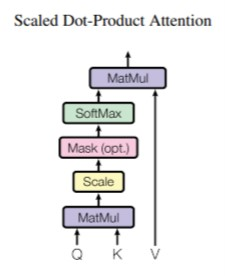

首先分别使用不同的转换矩阵得到$a^i$所对应的q、k、v，然后q和k做点积，再将得到的结果通过softmax层得到一个标量，即注意力权重；最后将得到的标量再和v做加权平均得到输出结果。

**NOTE：**这里相较于普通的注意力机制的计算过程不同的是：在得到注意力权重后除以了$\sqrt{d_{k}}$。这样做的道理在于：根据softmax的函数曲线可知，在$x=0$附近的梯度较大，而在两侧的曲线较为平缓，那么梯度值相应较小，不利于反向传播。因此这样可以避免softmax得到的梯度太小，从而提升训练效果，这也是标题中Scaled的来源。

In [0]:
## 这里使用前面得到的emb_inp来直观的理解一下Scaled dot-product attention的运行机制
#
# 设置种子，保证结果的复现
tf.random.set_seed(9527)

# Self-attention中的Q、K、V
# Q(K/V) shape = (batch_size, seq_len,depth)
q = emb_inp
k = emb_inp
# 随机从均匀分布中生成一个V
v = tf.cast(tf.math.greater(tf.random.uniform(shape=emb_inp.shape), 0.5), tf.float32)

v

<tf.Tensor: id=2245288, shape=(2, 8, 4), dtype=float32, numpy=
array([[[1., 0., 0., 0.],
        [0., 1., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 1.]],

       [[1., 0., 1., 1.],
        [1., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.]]], dtype=float32)>

In [0]:
# Google官方实现，注意输入和输出的形式
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """
  # Q和K做点积
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # 获取放缩所用的dk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)  # 取得 seq_k 的序列長度
  # scaled_attention_logits shape = (batch_size,seq_len.seq_len_k)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)  # scale by sqrt(dk)

  # 將mask「加」到被丟入 softmax 前的 logits
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # 将得到的注意力权重通过softmax层得到总和为1的权重值
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
  
  # 上一步得到的权重值和V做加权平均
  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

仔细观察scaled_dot_product_attention(q, k, v, mask)中的scaled_attention_logits += (mask * -1e9)这一句，这里mask和一个负的无穷大的数相乘。回想一下前面的padding mask部分，补齐的地方对应在mask向量中的位置为 1 ，那么与负的无穷大的数相乘得到的结果自然也是负的无穷大，那么经过softmax后值趋于零，这里 q 中的子词就不会关注 k 中补齐的部分。

In [0]:
# 这里不加入mask来简单的演示Scaled dot product attention的原理
mask = None
output, attention_weights = scaled_dot_product_attention(q, k, v, mask)
# output：注意力机制的结果
print("output:", output)
print("-" * 20)
# attention weights：句子q里每个子词对句子k里每个子词的注意力权重
print("attention_weights:", attention_weights)

output: tf.Tensor(
[[[0.37506962 0.37499517 0.37492687 0.49992454]
  [0.37502852 0.37497538 0.37498298 0.49997553]
  [0.3749036  0.37495515 0.37488088 0.5001605 ]
  [0.37526846 0.37492102 0.37513757 0.49988878]
  [0.37493467 0.37501413 0.37494898 0.5000182 ]
  [0.37504357 0.3749828  0.37496978 0.5000128 ]
  [0.3749243  0.37503862 0.374973   0.49998325]
  [0.3749243  0.37503862 0.374973   0.49998325]]

 [[0.6251087  0.24993587 0.6249208  0.3750515 ]
  [0.62501377 0.25004596 0.624921   0.37504268]
  [0.62511134 0.24993005 0.62473077 0.37499848]
  [0.6251209  0.2499639  0.6249559  0.37505007]
  [0.62502897 0.2499575  0.6247836  0.37499753]
  [0.62518305 0.250144   0.62513065 0.37514   ]
  [0.62506306 0.25002798 0.6250329  0.37506384]
  [0.62490237 0.2499001  0.6249851  0.3749146 ]]], shape=(2, 8, 4), dtype=float32)
--------------------
attention_weights: tf.Tensor(
[[[0.12514858 0.12506038 0.12492935 0.12491893 0.12500213 0.124929
   0.1250058  0.1250058 ]
  [0.12504144 0.12517536 0.12500

In [0]:
# 为inp生成对应的 padding mask
def create_padding_mask(seq):
  # padding mask 的工作就是把索引序列中为 0 的位置设为 1
  mask = tf.cast(tf.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :] #　broadcasting

print("inp:", inp)
inp_mask = create_padding_mask(inp)
print("-" * 20)
print("inp_mask:", inp_mask)

inp: tf.Tensor(
[[8135  105   10 1304 7925 8136    0    0]
 [8135   17 3905 6013   12 2572 7925 8136]], shape=(2, 8), dtype=int64)
--------------------
inp_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 8), dtype=float32)


In [0]:
# 将inp_mask将至 3 维，并和q、k、v共同参与计算，注意权重的变化
mask = tf.squeeze(inp_mask, axis=1) # (batch_size, 1, seq_len_q)
_, attention_weights = scaled_dot_product_attention(q, k, v, mask)

# 第一个句子的每个子词对最后两个补齐的部分注意力权重为 0 
print("attention_weights:", attention_weights)

attention_weights: tf.Tensor(
[[[0.16686736 0.16674975 0.16657504 0.16656116 0.1666721  0.16657458
   0.         0.        ]
  [0.16672012 0.16689868 0.16666505 0.16663694 0.16667555 0.1664037
   0.         0.        ]
  [0.166583   0.16670264 0.16691196 0.1665613  0.16664173 0.16659941
   0.         0.        ]
  [0.1665617  0.1666671  0.16655387 0.167138   0.16644852 0.16663083
   0.         0.        ]
  [0.16673139 0.16676448 0.16669303 0.1665072  0.16673715 0.16656673
   0.         0.        ]
  [0.16666476 0.16652338 0.1666816  0.1667205  0.16659763 0.16681209
   0.         0.        ]
  [0.16676621 0.16677828 0.16663395 0.1664758  0.1667804  0.1665654
   0.         0.        ]
  [0.16676621 0.16677828 0.16663395 0.1664758  0.1667804  0.1665654
   0.         0.        ]]

 [[0.12511563 0.12493791 0.12508401 0.12506124 0.12502599 0.12490988
   0.12496921 0.1248961 ]
  [0.12499674 0.12514375 0.12497083 0.1249373  0.12508081 0.12496513
   0.12502734 0.1248781 ]
  [0.12506844 0.12489

In [0]:
# 只看 3 维的注意力权重矩阵最后一个维度的最后两个值
attention_weights[:, :, -2:]

<tf.Tensor: id=2245331, shape=(2, 8, 2), dtype=float32, numpy=
array([[[0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.12496921, 0.1248961 ],
        [0.12502734, 0.1248781 ],
        [0.12486039, 0.12490829],
        [0.12496444, 0.12492301],
        [0.12493192, 0.12490424],
        [0.12506308, 0.12485934],
        [0.12504014, 0.12491234],
        [0.12496411, 0.12512498]]], dtype=float32)>

#### NOTE

这里 q 和 k 是相同的嵌入向量，相当于句子中的每个子词都去关注同句中其他位置的子词，从而从中获取表示的信息，这就是所谓的Self-attention。如果 q 和 k 分别是Decoder的输出和Encoder的输出，那么就是计算Decoder在生成某一个词时，它的隐状态计算输入序列中不同子词的注意力权重，从而得到新的context vector，也就是一般的Seq2Seq模型中的注意力机制的使用。

In [0]:
## look ahead mask
# 建立一個 2 维矩阵，维度為 (size, size)，其mask为右上三角矩阵
# 表示每一时刻只有已生成的位置是可以关注的
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

seq_len = emb_tar.shape[1] # 这里使用中文的词嵌入向量
look_ahead_mask = create_look_ahead_mask(seq_len)
print("emb_tar:", emb_tar)
print("-" * 20)

# 注意look_ahead_mask的输入形式，值为 1 的部分经过softmax后值趋于零，表示无法从这些位置得到信息
# look_ahead_mask shape = (seq_len,embeding_dim)
print("look_ahead_mask", look_ahead_mask)

emb_tar: tf.Tensor(
[[[ 0.00100154  0.02250249 -0.0408453  -0.03395625]
  [ 0.03035182  0.02689043 -0.04268903  0.03850842]
  [-0.03303015  0.03113339 -0.01500882  0.04115296]
  [-0.0260061  -0.00518541 -0.00464231  0.04862784]
  [ 0.01301358 -0.04549932  0.00708313 -0.01378647]
  [ 0.02436458 -0.04894441 -0.02432488 -0.02768328]
  [ 0.02250788  0.01626289 -0.0321715   0.02510258]
  [-0.04279016 -0.01537494  0.02144868 -0.04766507]
  [-0.04279016 -0.01537494  0.02144868 -0.04766507]
  [-0.04279016 -0.01537494  0.02144868 -0.04766507]]

 [[ 0.00100154  0.02250249 -0.0408453  -0.03395625]
  [-0.03975113  0.03147823  0.04613913  0.03317541]
  [-0.01448536 -0.02721623  0.0466414   0.00501192]
  [-0.03876447  0.02261052 -0.03871229  0.00696427]
  [ 0.01843901  0.03112211  0.04172729 -0.02785325]
  [ 0.0095794  -0.02647529 -0.02226598  0.00110232]
  [ 0.03891832 -0.0174     -0.03329356 -0.00945352]
  [ 0.00608505 -0.0193133  -0.02278407 -0.01182847]
  [ 0.02436458 -0.04894441 -0.02432488 -0.

In [0]:
# 使用中文的batch来看一下scaled_dot_product_attention的运算
temp_q = temp_k = emb_tar
temp_v = tf.cast(tf.math.greater(
    tf.random.uniform(shape=emb_tar.shape), 0.5), tf.float32)

_, attention_weights = scaled_dot_product_attention(temp_q, temp_k, temp_v, look_ahead_mask)

# attention_weights的输出为下三角矩阵，显示了在生成某个词时从前面已生成部分的子词所得到的注意力权重
# 最为直观的是第一行只有（1,1）值为 1 ，其余都为 0 ，是因为此时只能看到它自己
print("attention_weights:", attention_weights)

attention_weights: tf.Tensor(
[[[1.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.49951524 0.50048476 0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.3329849  0.33334753 0.33366755 0.         0.         0.
   0.         0.         0.         0.        ]
  [0.249631   0.24997401 0.25017738 0.25021756 0.         0.
   0.         0.         0.         0.        ]
  [0.19998352 0.19990057 0.1998148  0.19998613 0.20031494 0.
   0.         0.         0.         0.        ]
  [0.1667013  0.16657957 0.16637161 0.16649558 0.16685948 0.1669925
   0.         0.         0.         0.        ]
  [0.14284083 0.1430274  0.14287145 0.14283015 0.14270726 0.14276871
   0.14295417 0.         0.         0.        ]
  [0.12504955 0.12474872 0.12494314 0.12495089 0.12508695 0.12505917
   0.12483381 0.12532783 0.         0.        ]
  [0.11112276 0.11085545 0.11102822 0.1110351  0.111156   0.11113133
   0.1

In [0]:
# 更为直接的显示
attention_weights[:, 0, :]

<tf.Tensor: id=2245371, shape=(2, 10), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [0]:
attention_weights[:, 1, :]

<tf.Tensor: id=2245376, shape=(2, 10), dtype=float32, numpy=
array([[0.49951524, 0.50048476, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.49898213, 0.50101787, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)>

### Multi-head Attention

$$\text{head}_{i} = \text{Attention}(QW_{i}^Q,KW_{i}^K,VE_{i}^V)$$

$$\text{MultiHead}(Q,K,V) = \text{Concat}(\text{head}_{1},...,\text{head}_{h})$$

Transformer中另一个重要的东西就是**多头注意力机制**，它的直觉来源于每个子词在不同的句子下对于同一个词的关注应该是不同的，那么将其映射到不同的表示子空间中得到的表示就应该是不同的。因此我们可以将Q、K、V先分别转换到$d_{model}$维空间中，然后分别将其拆成多个较低维的N个q、k、v，这也就是所谓的多头，其中N作为超参数可以自由设定，N越大理论上获得的信息越多，但同时也带来了模型计算复杂度的增加。

然后将得到的多个q、k、v都喂给scaled_dot_product_attention()得到N个结果，接着将N个结果拼接起来，最后通过一个线性转换得到Multi-head attention的输出。

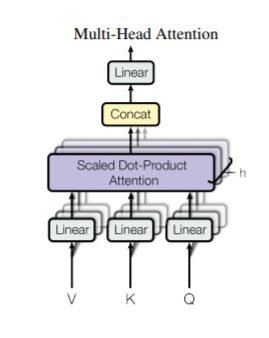


In [0]:
def split_heads(x, d_model, num_heads):
  # x.shape: (batch_size, seq_len, d_model)
  batch_size = tf.shape(x)[0]
  
  # 我們要确保维度`d_model` 可以被平分成 `num_heads` 个 `depth` 维度
  assert d_model % num_heads == 0
  depth = d_model // num_heads  # 划分后表示子空间的维度
  
  # 将最后一个 d_model 维度分成 num_heads 个 depth 维度，最后一个维度变成两个维度，x 从 3 维到 4 维
  # (batch_size, seq_len, num_heads, depth)
  reshaped_x = tf.reshape(x, shape=(batch_size, -1, num_heads, depth))
  
  # 將 head 的维度拉前使得最后兩个维度为子词以及其对应的 depth 向量
  # (batch_size, num_heads, seq_len, depth)
  output = tf.transpose(reshaped_x, perm=[0, 2, 1, 3])
  
  return output

#  `emb_inp` 里的子词本來就是 4 维的词嵌入向量
d_model = 4
# 将 4 维的词嵌入向量划分为 2 头的 2 维矩阵
num_heads = 2
x = emb_inp

output = split_heads(x, d_model, num_heads)  
print("x:", x)
# 从output中可以很直观的看出划分后的结果，按列划分，每两列为 1 头的嵌入向量
# shape=(2, 2, 8, 2)表示 2 批次数据按 N=2 进行划分，最后得到的结果向量长度仍为 8 ，但embedding_dim = 2
print("output:", output)

x: tf.Tensor(
[[[-0.01139329  0.01229278  0.03950438 -0.0395899 ]
  [-0.03753178  0.04810501  0.00495262 -0.01980923]
  [-0.04847762 -0.01453701 -0.03063028 -0.01865565]
  [ 0.03877607  0.04025192 -0.04581488 -0.03769145]
  [-0.02710364  0.00806242  0.01828117  0.00159191]
  [ 0.01875322 -0.02994844 -0.00705097 -0.01912252]
  [-0.0208289   0.01274401  0.03311023  0.01455362]
  [-0.0208289   0.01274401  0.03311023  0.01455362]]

 [[-0.01139329  0.01229278  0.03950438 -0.0395899 ]
  [-0.00584363  0.0104764   0.04166264  0.03220595]
  [ 0.04675562  0.03685777  0.03340571 -0.04201565]
  [-0.00773854  0.01943834  0.01579637 -0.04011631]
  [ 0.02852057  0.01556729  0.0491894  -0.00419093]
  [-0.04344189  0.04366796 -0.01890308  0.00424111]
  [-0.02710364  0.00806242  0.01828117  0.00159191]
  [ 0.01875322 -0.02994844 -0.00705097 -0.01912252]]], shape=(2, 8, 4), dtype=float32)
output: tf.Tensor(
[[[[-0.01139329  0.01229278]
   [-0.03753178  0.04810501]
   [-0.04847762 -0.01453701]
   [ 0.0387

In [0]:
## 实现多头注意力机制的 keras layer
class MultiHeadAttention(tf.keras.layers.Layer):
    # 在初始的時候指定输出维度`d_model` 和 `num_heads，
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()

        self.num_heads = num_heads 
        self.d_model = d_model 

        assert d_model % self.num_heads == 0  # 确保可以正确划分

        self.depth = d_model // self.num_heads  # 每个 head 里子词的新的 repr. 维度

        # 分別给 q, k, v 的 3 个线性转换 
        self.wq = tf.keras.layers.Dense(d_model)  
        self.wk = tf.keras.layers.Dense(d_model)  # 这里并没有指定 activation func
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)  # 多个结果拼接后的线性转换
  
    def split_heads(self, x, batch_size):
        # Split the last dimension into (num_heads, depth).
        # Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)

        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    # multi-head attention 的前向传播过程
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        # 将 q, k, v 都各自做一次线性转换到 `d_model` 维空间
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        # 将最后一个`d_model` 维度分成 `num_heads` 个 `depth` 维度
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # 利用 broadcasting 让每个句子的每个 head 的 qi, ki, vi 都各自进行注意力机制的计算
        # 输出会多一个维度
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)

        # 跟我们在 `split_heads` 做的事情刚好相反，先做 transpose 再做 reshape
        # 将 `num_heads` 个 `depth` 维度拼接回原來的 `d_model` 维度
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        # (batch_size, seq_len_q, num_heads, depth)
        
        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model)) 
        # (batch_size, seq_len_q, d_model)

        # 最后做一次线性转换
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        # 输出跟 scaled_dot_product_attention()一样包含 output 和 attention_weightd
        # output.shape = (batch_size, seq_len_q, d_model)
        # attention_weights.shape = (batch_size, num_heads, seq_len_q, seq_len_k)    
        return output, attention_weights

In [0]:
# emb_inp.shape == (batch_size, seq_len, d_model) == (2, 8, 4)
assert d_model == emb_inp.shape[-1]  == 4
num_heads = 2

print(f"d_model: {d_model}")
print(f"num_heads: {num_heads}\n")

# 初始化一个 multi-head attention layer
mha = MultiHeadAttention(d_model, num_heads)

# 这里同样简单的对 q 和 k 使用相同的词嵌入向量
v = k = q = emb_inp
padding_mask = create_padding_mask(inp)
print("q.shape:", q.shape)
print("k.shape:", k.shape)
print("v.shape:", v.shape)
print("padding_mask.shape:", padding_mask.shape)

output, attention_weights = mha(v, k, q, mask)

# output_shape == emb_inp_shape
print("output.shape:", output.shape)
print("attention_weights.shape:", attention_weights.shape)

print("\noutput:", output)

d_model: 4
num_heads: 2

q.shape: (2, 8, 4)
k.shape: (2, 8, 4)
v.shape: (2, 8, 4)
padding_mask.shape: (2, 1, 1, 8)
output.shape: (2, 8, 4)
attention_weights.shape: (2, 2, 8, 8)

output: tf.Tensor(
[[[ 0.01527098 -0.01789774 -0.01523319  0.0009215 ]
  [ 0.01526419 -0.01788679 -0.01522307  0.00091816]
  [ 0.01526468 -0.017891   -0.01522538  0.00091816]
  [ 0.01525943 -0.01788627 -0.01523652  0.00090566]
  [ 0.01527707 -0.01790334 -0.01523186  0.00092741]
  [ 0.01527615 -0.01790738 -0.01524307  0.00092123]
  [ 0.01528278 -0.01790921 -0.01523449  0.00093178]
  [ 0.01528278 -0.01790921 -0.01523449  0.00093178]]

 [[-0.00380177  0.00312115  0.01812393  0.01823709]
  [-0.00377216  0.00309893  0.01810931  0.01823567]
  [-0.00378912  0.0031084   0.01809814  0.01822169]
  [-0.00380559  0.00312412  0.0181221   0.01823044]
  [-0.00377565  0.00309886  0.01809984  0.01822967]
  [-0.00380575  0.00312865  0.01813124  0.01822983]
  [-0.00379382  0.00311651  0.01812373  0.01823533]
  [-0.00379186  0.003

## Transformer

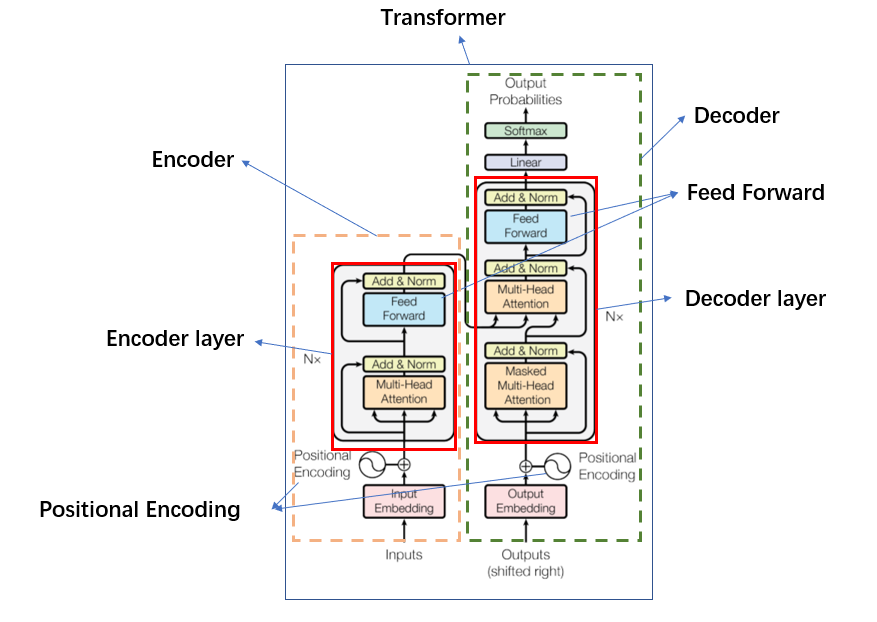

Transformer是一种完全基于自注意力机制的Seq2Seq模型，因此同样包含Encoder和Decoder：
- Encoder输入的英文序列会通过其中的N个子层并被转换维一个相同长度的序列，每层都会为自己的输入序列中的子词产生新的表示，然后在传到下一层
- Decoder在预测下一个中文的子词时会同时关注Encoder输出序列中所有的英文子词的表示，同时关注自身已生成的部分

Encoder中的Encoder layer又分为两个sub_layer;Decoder中的Decoder layer又分为3个sub_layer。因此从sub_layer出发来看，Transformer的结构可以表示为：

- Transformer
    - Encoder
        -inpute embedding
        - positional embedding
        - N Encoder layers
            - sub_layer 1: self_attentino
            - sub_layer 2: Feed forward
    - Decoder
        - output embedding
        - positional embedding
        - N Decoder layers
            - sub_layer 1:Self-attention
            - sub_layer 2:Edcder-encoder attention
            - sub_layer 3:Feed forward
    - Final Dense layer
    

In [0]:
#  Feed Forward layer
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [0]:
batch_size = 64
seq_len = 10
d_model = 512
dff = 2048

x = tf.random.uniform((batch_size, seq_len, d_model))
ffn = point_wise_feed_forward_network(d_model, dff)
out = ffn(x)

# x shape == (batch_size,seq_len.d_model)
# output shape == (batch_size,seq_len,d_model)
print("x.shape:", x.shape)
print("out.shape:", out.shape)

x.shape: (64, 10, 512)
out.shape: (64, 10, 512)


#### NOTE

同一个子词不会因为位置的改变而造成FFN产生不同的输出。而实际中不同的layer会有不同参数的FFN，因此每个layer中的FFN所做的线性转换是不同的。

另外尽管对所有位置的子词做同样的转换，但每个转换是独立进行的，因此称为Position-wise-DFeed-Forward Networks。

In [0]:
d_model = 4 # FFN 的输入输出张量的最后一维都是 `d_model`
dff = 6

# 构建一个小的 FFN
small_ffn = point_wise_feed_forward_network(d_model, dff)

dummy_sentence = tf.constant([[5, 5, 6, 6], 
                              [5, 5, 6, 6], 
                              [9, 5, 2, 7], 
                              [9, 5, 2, 7],
                              [9, 5, 2, 7]], dtype=tf.float32)
small_ffn(dummy_sentence)

<tf.Tensor: id=2245723, shape=(5, 4), dtype=float32, numpy=
array([[ 2.8674245, -2.174698 , -1.3073452, -6.4233937],
       [ 2.8674245, -2.174698 , -1.3073452, -6.4233937],
       [ 3.650207 , -0.973258 , -2.4126565, -6.5094995],
       [ 3.650207 , -0.973258 , -2.4126565, -6.5094995],
       [ 3.650207 , -0.973258 , -2.4126565, -6.5094995]], dtype=float32)>

In [0]:
## Encoder layer
#
# Encoder 包含 N 个Encoder Layer，而每个 Encoder Layer 又有兩个 sub-layers: MHA & FFN
class EncoderLayer(tf.keras.layers.Layer):
  # Transformer 文章中 dropout rate = 0.1
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # layer norm 在RNN中效果要优于BN，因此被广泛的使用
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  # 需要设置 training 这个指示变量是因为 dropout 在训练和测试中是不同的
  def call(self, x, training, mask):
    # 除了 `attn`，其他张量的 shape 都为(batch_size, input_seq_len, d_model)
    # attn.shape == (batch_size, num_heads, input_seq_len, input_seq_len)
    
    # sub-layer 1: MHA
    # Encoder 利用注意力机制关注自己当前的序列，因此 v, k, q 全部都是自己
    # 另外还需要 padding mask 來mask掉输入序列中的 <pad> token
    attn_output, attn = self.mha(x, x, x, mask)  
    attn_output = self.dropout1(attn_output, training=training) 
    out1 = self.layernorm1(x + attn_output)  
    
    # sub-layer 2: FFN
    ffn_output = self.ffn(out1) 
    ffn_output = self.dropout2(ffn_output, training=training)  # 記得 training
    out2 = self.layernorm2(out1 + ffn_output)
    
    return out2

In [0]:
d_model = 4
num_heads = 2
dff = 8

# 新建一个 Encoder Layer
enc_layer = EncoderLayer(d_model, num_heads, dff)
padding_mask = create_padding_mask(inp)  # 构件针对当前 batch 使用的 padding mask
enc_out = enc_layer(emb_inp, training=False, mask=padding_mask)  # (batch_size, seq_len, d_model)

print("inp:", inp)
print("-" * 20)
print("padding_mask:", padding_mask)
print("-" * 20)
print("emb_inp:", emb_inp)
print("-" * 20)
print("enc_out:", enc_out)
assert emb_inp.shape == enc_out.shape

inp: tf.Tensor(
[[8135  105   10 1304 7925 8136    0    0]
 [8135   17 3905 6013   12 2572 7925 8136]], shape=(2, 8), dtype=int64)
--------------------
padding_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 8), dtype=float32)
--------------------
emb_inp: tf.Tensor(
[[[-0.01139329  0.01229278  0.03950438 -0.0395899 ]
  [-0.03753178  0.04810501  0.00495262 -0.01980923]
  [-0.04847762 -0.01453701 -0.03063028 -0.01865565]
  [ 0.03877607  0.04025192 -0.04581488 -0.03769145]
  [-0.02710364  0.00806242  0.01828117  0.00159191]
  [ 0.01875322 -0.02994844 -0.00705097 -0.01912252]
  [-0.0208289   0.01274401  0.03311023  0.01455362]
  [-0.0208289   0.01274401  0.03311023  0.01455362]]

 [[-0.01139329  0.01229278  0.03950438 -0.0395899 ]
  [-0.00584363  0.0104764   0.04166264  0.03220595]
  [ 0.04675562  0.03685777  0.03340571 -0.04201565]
  [-0.00773854  0.01943834  0.01579637 -0.04011631]
  [ 0.02852057  0.01556729  0.0491894  -0.00419093]
  [

In [0]:
## Decoder layer
#
# Decoder 里会有 N 个 Decoder Layer，
# 而 DecoderLayer 又有三个 sub-layers: 自注意的 MHA, 关注 Encoder 输出的 MHA & FFN
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    # 3 个 sub-layers 的主角
    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    # 定义每个 sub-layer 用的 Layer Norm
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    # 定义每个 sub-layer 用的 Dropout
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           combined_mask, inp_padding_mask):
    # 所有 sub-layers 的主要输出都是 (batch_size, target_seq_len, d_model)
    # enc_output 为 Encoder 输出序列，shape 为(batch_size, input_seq_len, d_model)
    # attn_weights_block_1 都是  (batch_size, num_heads, target_seq_len, target_seq_len)
    # attn_weights_block_2 都是  (batch_size, num_heads, target_seq_len, input_seq_len)

    # sub-layer 1: Decoder layer 自己对输出序列做注意力，因此 Q、K、V 都是 x
    # 我们同时需要 look ahead mask 以及输出序列的 padding mask 
    # 來避免前面已生成的子词关注到未來的子词以及 <pad>
    attn1, attn_weights_block1 = self.mha1(x, x, x, combined_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # sub-layer 2: Decoder layer 关注 Encoder 的最后输出，因此 V、K 为enc_output
    # 需要对 Encoder 的输出使用 padding mask 避免关注到 <pad>
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, inp_padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    # sub-layer 3: FFN 部分跟 Encoder layer 完全一样
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    # 除了主要输出 `out3` 以外，输出 multi-head 注意权重方便之后理解模型內部状况
    return out3, attn_weights_block1, attn_weights_block2

In [0]:
tar_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[-1])

# conbined_mask 只需对两个mask取大即可
combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

print("tar:", tar)
print("-" * 20)
print("tar_padding_mask:", tar_padding_mask)
print("-" * 20)
print("look_ahead_mask:", look_ahead_mask)
print("-" * 20)
print("combined_mask:", combined_mask)

tar: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0    0]
 [4201  162  467  421  189   14    7  553    3 4202]], shape=(2, 10), dtype=int64)
--------------------
tar_padding_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 10), dtype=float32)
--------------------
look_ahead_mask: tf.Tensor(
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)
--------------------
combined_mask: tf.Tensor(
[[[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0.

In [0]:
(batch_size, num_heads, seq_len_tar, seq_len_tar) = (2, 1, 10, 10)

In [0]:
d_model = 4
num_heads = 2
dff = 8
dec_layer = DecoderLayer(d_model, num_heads, dff)

# 源、目标语言的序列都需要 padding mask
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar)

# masked MHA 用的mask，把 padding 跟未來子词都mask掉
look_ahead_mask = create_look_ahead_mask(tar.shape[-1])
combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

# 实际初始一个 decoder layer 并做 3 个 sub-layers 的计算
dec_out, dec_self_attn_weights, dec_enc_attn_weights = dec_layer(
    emb_tar, enc_out, False, combined_mask, inp_padding_mask)

print("emb_tar:", emb_tar)
print("-" * 20)
print("enc_out:", enc_out)
print("-" * 20)
print("dec_out:", dec_out)
assert emb_tar.shape == dec_out.shape
print("-" * 20)
print("dec_self_attn_weights.shape:", dec_self_attn_weights.shape)
print("dec_enc_attn_weights:", dec_enc_attn_weights.shape)

emb_tar: tf.Tensor(
[[[ 0.00100154  0.02250249 -0.0408453  -0.03395625]
  [ 0.03035182  0.02689043 -0.04268903  0.03850842]
  [-0.03303015  0.03113339 -0.01500882  0.04115296]
  [-0.0260061  -0.00518541 -0.00464231  0.04862784]
  [ 0.01301358 -0.04549932  0.00708313 -0.01378647]
  [ 0.02436458 -0.04894441 -0.02432488 -0.02768328]
  [ 0.02250788  0.01626289 -0.0321715   0.02510258]
  [-0.04279016 -0.01537494  0.02144868 -0.04766507]
  [-0.04279016 -0.01537494  0.02144868 -0.04766507]
  [-0.04279016 -0.01537494  0.02144868 -0.04766507]]

 [[ 0.00100154  0.02250249 -0.0408453  -0.03395625]
  [-0.03975113  0.03147823  0.04613913  0.03317541]
  [-0.01448536 -0.02721623  0.0466414   0.00501192]
  [-0.03876447  0.02261052 -0.03871229  0.00696427]
  [ 0.01843901  0.03112211  0.04172729 -0.02785325]
  [ 0.0095794  -0.02647529 -0.02226598  0.00110232]
  [ 0.03891832 -0.0174     -0.03329356 -0.00945352]
  [ 0.00608505 -0.0193133  -0.02278407 -0.01182847]
  [ 0.02436458 -0.04894441 -0.02432488 -0.

#### Positional encoding

Transformer 虽然可以做到并行化计算，但同时丢失了位置信息，因此我们需要另外加入位置编码来提供相应的位置信息。实际操作中是将其直接加入到输入的英文/中文词嵌入向量中，这样使得词嵌入向量在d_model维度的空间中，不仅因为语义相近而靠近，同时也会因为位置相近而靠近。

positional encoding的计算公式为：
$$PE(pos,2i) = \sin (pos/10000^{2i/d_{model}}) \\ PE(pos,2i+1) = \cos (pos/10000^{2i/d_{model}})$$

这样编码的好处在于：给定某一个位置的编码PE(pos)后，距离它k个单位的位置的编码PE(pos + k)可以表示为PE(pos)的线性函数。

In [0]:
# 以下直接参考 TensorFlow 官方 tutorial 
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  sines = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  cosines = np.cos(angle_rads[:, 1::2])
  
  pos_encoding = np.concatenate([sines, cosines], axis=-1)
  
  pos_encoding = pos_encoding[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)


seq_len = 50
d_model = 512

pos_encoding = positional_encoding(seq_len, d_model)
pos_encoding

<tf.Tensor: id=2246679, shape=(1, 50, 512), dtype=float32, numpy=
array([[[ 0.        ,  0.        ,  0.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.84147096,  0.8218562 ,  0.8019618 , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.9092974 ,  0.9364147 ,  0.95814437, ...,  1.        ,
          1.        ,  1.        ],
        ...,
        [ 0.12357312,  0.97718984, -0.24295525, ...,  0.9999863 ,
          0.99998724,  0.99998814],
        [-0.76825464,  0.7312359 ,  0.63279754, ...,  0.9999857 ,
          0.9999867 ,  0.9999876 ],
        [-0.95375264, -0.14402692,  0.99899054, ...,  0.9999851 ,
          0.9999861 ,  0.9999871 ]]], dtype=float32)>

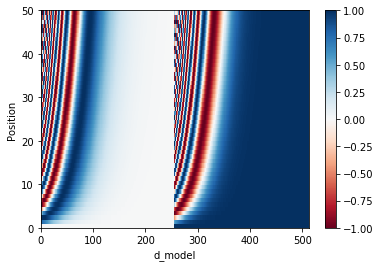

In [0]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d_model')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [0]:
class Encoder(tf.keras.layers.Layer):
  
  # - num_layers: Encoder layer的数目
  # - input_vocab_size: 词典大小
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
    
    # 建立 `num_layers` 个 Encoder Layers
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):
    #  x.shape == (batch_size, input_seq_len)
    # 以下各 layer 的输出都是 (batch_size, input_seq_len, d_model)
    input_seq_len = tf.shape(x)[1]
    
    # 将 2 维的索引序列转成 3 维的词嵌入张量，并根据论文乘上 sqrt(d_model)
    # 再加上对应的位置编码
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :input_seq_len, :]

    # 对 embedding 跟位置编码的综合 regularization
    x = self.dropout(x, training=training)
    
    # 通过 N 个 EncoderLayer 编码
    for i, enc_layer in enumerate(self.enc_layers):
      x = enc_layer(x, training, mask)
      # 以下只是用來 demo EncoderLayer outputs
      #print('-' * 20)
      #print(f"EncoderLayer {i + 1}'s output:", x)
      
    
    return x 

In [0]:
num_layers = 2 
d_model = 4
num_heads = 2
dff = 8
input_vocab_size = subword_encoder_en.vocab_size + 2 

# 初始化一个 Encoder
encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size)

# 将 2 维的索引序列丟入 Encoder 编码
enc_out = encoder(inp, training=False, mask=None)
print("inp:", inp) # inp shape == (batch_size,seq_len)
print("-" * 20)    # output shape == (batch_size,seq_len,d_model)
print("enc_out:", enc_out)

inp: tf.Tensor(
[[8135  105   10 1304 7925 8136    0    0]
 [8135   17 3905 6013   12 2572 7925 8136]], shape=(2, 8), dtype=int64)
--------------------
enc_out: tf.Tensor(
[[[-0.80654097 -0.5846039  -0.31439844  1.7055433 ]
  [-0.46891153 -0.57408124 -0.6840381   1.727031  ]
  [-0.319709   -0.17782518 -1.1191479   1.616682  ]
  [-0.49274105  0.26990706 -1.2412689   1.4641027 ]
  [-0.88477194  0.16279429 -0.8493918   1.5713693 ]
  [-0.96625364 -0.25279218 -0.4533522   1.6723981 ]
  [-0.8476429  -0.5615218  -0.28872433  1.6978891 ]
  [-0.61957765 -0.5919263  -0.51938564  1.7308894 ]]

 [[-0.8083886  -0.56457365 -0.33460823  1.7075704 ]
  [-0.50152016 -0.5214133  -0.7037289   1.7266623 ]
  [-0.34244898 -0.11313835 -1.1444559   1.6000432 ]
  [-0.5072439   0.21401608 -1.2050328   1.4982607 ]
  [-0.88611245  0.26368466 -0.9036027   1.5260304 ]
  [-0.96629447 -0.21083635 -0.49055386  1.6676848 ]
  [-0.86832803 -0.5383212  -0.28836083  1.6950101 ]
  [-0.6246328  -0.57586765 -0.5305909   1.7310

In [0]:
class Decoder(tf.keras.layers.Layer):
  
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
  
  def call(self, x, enc_output, training, combined_mask, inp_padding_mask):
    
    tar_seq_len = tf.shape(x)[1]
    attention_weights = {}  # 用來存放每个 Decoder layer 的注意权重
    
    x = self.embedding(x)  # (batch_size, tar_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :tar_seq_len, :]
    x = self.dropout(x, training=training)

    
    for i, dec_layer in enumerate(self.dec_layers):
      x, block1, block2 = dec_layer(x, enc_output, training,combined_mask, inp_padding_mask)
      
      # 将从每个 Decoder layer 取得的注意权重全部存下來回传，方便观察
      attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2
    
    # x.shape == (batch_size, tar_seq_len, d_model)
    return x, attention_weights

In [0]:
num_layers = 2 
d_model = 4
num_heads = 2
dff = 8
target_vocab_size = subword_encoder_zh.vocab_size + 2 

inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[1])
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

# 初始化 Decoder
decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size)

# 將 2 维的索引序列以及mask丟入 Decoder
print("tar:", tar)
print("-" * 20)
print("combined_mask:", combined_mask)
print("-" * 20)
print("enc_out:", enc_out)
print("-" * 20)
print("inp_padding_mask:", inp_padding_mask)
print("-" * 20)
dec_out, attn = decoder(tar, enc_out, training=False, 
                        combined_mask=combined_mask,
                        inp_padding_mask=inp_padding_mask)
print("dec_out:", dec_out)
print("-" * 20)
for block_name, attn_weights in attn.items():
  print(f"{block_name}.shape: {attn_weights.shape}")

tar: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0    0]
 [4201  162  467  421  189   14    7  553    3 4202]], shape=(2, 10), dtype=int64)
--------------------
combined_mask: tf.Tensor(
[[[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]]


 [[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 10, 10), dtype=float32)
--------------------
enc_out: tf.Tensor(
[[[-0.80654097 

In [0]:
# Transformer 之上已经沒有其他 layers 了，我们使用 tf.keras.Model 建立一个模型
class Transformer(tf.keras.Model):

  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, rate)
    # 這個 FFN 输出跟中文字典一样大的 logits 数，等通过 softmax 就代表每个中文字的出现概率
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  
  # enc_padding_mask 跟 dec_padding_mask 都是英文序列的 padding mask，
  # 只是一个给 Encoder layer 的 MHA 用，一个是给 Decoder layer 的 MHA 2 使用
  def call(self, inp, tar, training, enc_padding_mask, 
           combined_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, combined_mask, dec_padding_mask)
    
    # 将 Decoder 输出通过最后一个 linear layer
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [0]:
num_layers = 1
d_model = 4
num_heads = 2
dff = 8

input_vocab_size = subword_encoder_en.vocab_size + 2
output_vocab_size = subword_encoder_zh.vocab_size + 2

# 因为要逐词预测，因此这里需要将目标序列左移一位作为Decoder的输入
tar_inp = tar[:, :-1]
tar_real = tar[:, 1:]

inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar_inp)
look_ahead_mask = create_look_ahead_mask(tar_inp.shape[1])
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

# 初始化 transformer
transformer = Transformer(num_layers, d_model, num_heads, dff, 
                          input_vocab_size, output_vocab_size)

# 将英文、中文序列丟入 Transformer 预测下个中文字的结果
predictions, attn_weights = transformer(inp, tar_inp, False, inp_padding_mask, 
                                        combined_mask, inp_padding_mask)

print("tar:", tar)
print("-" * 20)
print("tar_inp:", tar_inp)
print("-" * 20)
print("tar_real:", tar_real)
print("-" * 20)
print("predictions:", predictions)

tar: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0    0]
 [4201  162  467  421  189   14    7  553    3 4202]], shape=(2, 10), dtype=int64)
--------------------
tar_inp: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0]
 [4201  162  467  421  189   14    7  553    3]], shape=(2, 9), dtype=int64)
--------------------
tar_real: tf.Tensor(
[[  10  241   80   27    3 4202    0    0    0]
 [ 162  467  421  189   14    7  553    3 4202]], shape=(2, 9), dtype=int64)
--------------------
predictions: tf.Tensor(
[[[ 0.00929452 -0.01123782  0.05421777 ... -0.01170466  0.00628542
   -0.07576236]
  [ 0.03640017 -0.01885041  0.05113849 ... -0.02349908  0.01716622
   -0.06729948]
  [ 0.05617092 -0.02265774  0.04667147 ... -0.02913139  0.0241506
   -0.05331099]
  ...
  [ 0.00905135 -0.01058669  0.05486142 ... -0.01039154  0.0058039
   -0.07445519]
  [ 0.02215609 -0.01478041  0.05375389 ... -0.0170105   0.01135763
   -0.07241639]
  [ 0.0478656  -0.02148081  0.04837158 ... -0.02759

In [0]:
# 选择损失项，这里使用的是交叉熵
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# 假设我们要解决的是一个 binary classifcation问题， 0 跟 1 个代表一个 label
real = tf.constant([1, 1, 0], shape=(1, 3), dtype=tf.float32)
pred = tf.constant([[0, 1], [0, 1], [0, 1]], dtype=tf.float32)
loss_object(real, pred)

<tf.Tensor: id=2249629, shape=(3,), dtype=float32, numpy=array([0.31326166, 0.31326166, 1.3132616 ], dtype=float32)>

In [0]:
print("predictions:", predictions)
print("-" * 20)
print(tf.reduce_sum(predictions, axis=-1))

predictions: tf.Tensor(
[[[ 0.00929452 -0.01123782  0.05421777 ... -0.01170466  0.00628542
   -0.07576236]
  [ 0.03640017 -0.01885041  0.05113849 ... -0.02349908  0.01716622
   -0.06729948]
  [ 0.05617092 -0.02265774  0.04667147 ... -0.02913139  0.0241506
   -0.05331099]
  ...
  [ 0.00905135 -0.01058669  0.05486142 ... -0.01039154  0.0058039
   -0.07445519]
  [ 0.02215609 -0.01478041  0.05375389 ... -0.0170105   0.01135763
   -0.07241639]
  [ 0.0478656  -0.02148081  0.04837158 ... -0.02759764  0.02148173
   -0.06043392]]

 [[ 0.00996658 -0.01115559  0.05453676 ... -0.0114185   0.00637141
   -0.07500792]
  [ 0.03897631 -0.01930442  0.0508956  ... -0.02409907  0.01803425
   -0.0656432 ]
  [ 0.05387272 -0.02244362  0.04702405 ... -0.02893805  0.02348556
   -0.05554678]
  ...
  [ 0.01048942 -0.01085559  0.05502523 ... -0.01070841  0.0062833
   -0.07385261]
  [ 0.02370835 -0.01504852  0.05381611 ... -0.01732858  0.01186723
   -0.07158875]
  [ 0.04920105 -0.02166032  0.0481827  ... -0.027812

In [0]:
# 定义损失函数
def loss_function(real, pred):
  #  mask 将序列中不等于 0 的位置视为 1，其余为 0 
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  # 计算所有位置的 cross entropy 但不求和
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask  # 只计算非 <pad> 位置的损失
  
  return tf.reduce_mean(loss_)

In [0]:
# 选择评估指标
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [0]:
num_layers = 4 
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = subword_encoder_en.vocab_size + 2
target_vocab_size = subword_encoder_zh.vocab_size + 2
dropout_rate = 0.1  

print("input_vocab_size:", input_vocab_size)
print("target_vocab_size:", target_vocab_size)

input_vocab_size: 8137
target_vocab_size: 4203


In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  # 预设 `warmup_steps` = 4000
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  
# 将定制的 learning rate schdeule 丟入 Adam opt.
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

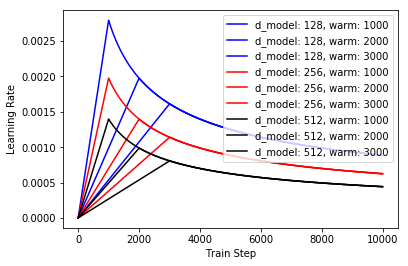

In [0]:
d_models = [128, 256, 512]
warmup_steps = [1000 * i for i in range(1, 4)]

schedules = []
labels = []
colors = ["blue", "red", "black"]
for d in d_models:
  schedules += [CustomSchedule(d, s) for s in warmup_steps]
  labels += [f"d_model: {d}, warm: {s}" for s in warmup_steps]

for i, (schedule, label) in enumerate(zip(schedules, labels)):
  plt.plot(schedule(tf.range(10000, dtype=tf.float32)), 
           label=label, color=colors[i // 3])

plt.legend()

plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [0]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, dropout_rate)

print(f"""这个 Transformer 有 {num_layers} 层 Encoder / Decoder layers
d_model: {d_model}
num_heads: {num_heads}
dff: {dff}
input_vocab_size: {input_vocab_size}
target_vocab_size: {target_vocab_size}
dropout_rate: {dropout_rate}

""")

這個 Transformer 有 4 層 Encoder / Decoder layers
d_model: 128
num_heads: 8
dff: 512
input_vocab_size: 8137
target_vocab_size: 4203
dropout_rate: 0.1




In [0]:
# 方便比较不同实验/ 不同超参数设定的結果
run_id = f"{num_layers}layers_{d_model}d_{num_heads}heads_{dff}dff_{train_perc}train_perc"
checkpoint_path = os.path.join(checkpoint_path, run_id)
log_dir = os.path.join(log_dir, run_id)

# tf.train.Checkpoint 保存一些东西，使得不必每次重新训练
# 保存模型以及 optimizer 的状态
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

# ckpt_manager 会去 checkpoint_path 看有沒有符合 ckpt 里定义东西
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果在 checkpoint 路径上有保存的checkpoint就加载进来
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  
  # 确认已训练了多少epoch
  last_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
  print(f'已读取最新的的 checkpoint，模型已训练{last_epoch} epochs。')
else:
  last_epoch = 0
  print("沒找到 checkpoint，从头训练。")

沒找到 checkpoint，從頭訓練。


In [0]:
# 为 Transformer 的 Encoder / Decoder 准备 mask
def create_masks(inp, tar):
  # 英文句子的 padding mask，要交給 Encoder layer 自注意力机制用的
  enc_padding_mask = create_padding_mask(inp)
  
  # 同样也是英文句子的 padding mask，但是是要交給 Decoder layer 的 MHA 2 
  # 关注 Encoder 输出序列用的
  dec_padding_mask = create_padding_mask(inp)
  
  # Decoder layer 的 MHA1 在做自注意力机制用的
  # `combined_mask` 是中文句子的 padding mask 跟 look ahead mask 的疊加
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [0]:
@tf.function  # 让 TensorFlow 帮我们将 eager code 优化并加速运算
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  # 记录 Transformer 的所有运算过程以方便之后做梯度下降
  with tf.GradientTape() as tape:
    #  `training` = True
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    # 计算左移一个字的序列跟模型预测分部之间的差异，当作 loss
    loss = loss_function(tar_real, predictions)

  # 计算梯度，更新参数
  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [0]:

EPOCHS = 30
print(f"此超参数组合的 Transformer 已经训练 {last_epoch} epochs。")
print(f"剩余 epochs：{min(0, last_epoch - EPOCHS)}")


# 用來写信息到 TensorBoard，
summary_writer = tf.summary.create_file_writer(log_dir)

for epoch in range(last_epoch, EPOCHS):
  start = time.time()
  
  # 重置记录TensorBoard 的 metrics
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # 一个 epoch 就是把我们定义的训练集一个一个 batch 拿出來处理，直到看完整个数据集
  for (step_idx, (inp, tar)) in enumerate(train_dataset):
    
    # 每次 step 就是将数据丟入 Transformer，让它生预测结果并计算梯度最小化 loss
    train_step(inp, tar)  

  # 每个 epoch 完成就保存一次checkpoint   
  if (epoch + 1) % 1 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  # 将 loss 以及 accuracy 写到 TensorBoard 上
  with summary_writer.as_default():
    tf.summary.scalar("train_loss", train_loss.result(), step=epoch + 1)
    tf.summary.scalar("train_acc", train_accuracy.result(), step=epoch + 1)
  
  print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))
  print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

此超參數組合的 Transformer 已經訓練 0 epochs。
剩餘 epochs：-30
Saving checkpoint for epoch 1 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-1
Epoch 1 Loss 5.1923 Accuracy 0.0195
Time taken for 1 epoch: 193.81880569458008 secs

Saving checkpoint for epoch 2 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-2
Epoch 2 Loss 4.2502 Accuracy 0.0594
Time taken for 1 epoch: 71.249103307724 secs

Saving checkpoint for epoch 3 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-3
Epoch 3 Loss 3.7397 Accuracy 0.0995
Time taken for 1 epoch: 71.23760175704956 secs

Saving checkpoint for epoch 4 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-4
Epoch 4 Loss 3.2614 Accuracy 0.1536
Time taken for 1 epoch: 71.90176820755005 secs

Saving checkpoint for epoch 5 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-5
Epoch 5 Loss 2.9614 Accuracy 0.1822
Time taken for 1 epoch: 71.93180513381958 secs

Saving checkpoint for epoch 6 at nmt/checkpoints/4la

In [0]:
%load_ext tensorboard
%tensorboard --logdir {./log}

In [0]:
# 給定一个英文句子，输出预测的中文索引数字序列以及注意权重 dict
def evaluate(inp_sentence):
  
  # 准备英文句子前后会加上的 <start>, <end>
  start_token = [subword_encoder_en.vocab_size]
  end_token = [subword_encoder_en.vocab_size + 1]
  
  # inp_sentence 是字符串，我们用 Subword Tokenizer 将其变成子词的索引序列
  # 并在前后加上 BOS / EOS
  inp_sentence = start_token + subword_encoder_en.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # 输入是一个只包含一个中文 <start> token 的序列
  decoder_input = [subword_encoder_zh.vocab_size]
  output = tf.expand_dims(decoder_input, 0)  # 增加 batch 维度
  
  # auto-regressive，一次生成一个中文字并将预测加到输入再度喂给 Transformer
  for i in range(MAX_LENGTH):
    # 每多一个生成的字就得产生新的mask
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    

    # 將序列中最后一个 distribution 取出，并将里面最大的当作模型最新的预测字
    predictions = predictions[: , -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # 遇到 <end> token 就停止回传，代表模型已预测完毕
    if tf.equal(predicted_id, subword_encoder_zh.vocab_size + 1):
      return tf.squeeze(output, axis=0), attention_weights
    
    # 將 Transformer 新预测的中文索引加到输出序列中，让 Decoder 可以在产生下个中文字的時候关注到最新的 `predicted_id`
    output = tf.concat([output, predicted_id], axis=-1)

  # 將 batch 的维度去掉后回传预测的中文索引序列
  return tf.squeeze(output, axis=0), attention_weights

In [0]:
sentence = "China, India, and others have enjoyed continuing economic growth."

# 取得预测的中文索引序列
predicted_seq, _ = evaluate(sentence)

# 过滤掉 <start> & <end> tokens 并用中文的 subword tokenizer 将索引序列还原回中文句子
target_vocab_size = subword_encoder_zh.vocab_size
predicted_seq_without_bos_eos = [idx for idx in predicted_seq if idx < target_vocab_size]
predicted_sentence = subword_encoder_zh.decode(predicted_seq_without_bos_eos)

print("sentence:", sentence)
print("-" * 20)
print("predicted_seq:", predicted_seq)
print("-" * 20)
print("predicted_sentence:", predicted_sentence)

sentence: China, India, and others have enjoyed continuing economic growth.
--------------------
predicted_seq: tf.Tensor(
[4201   16    4   37  386  101    8   34   32    4   33  110    5  104
  166   22   52  107   84    3], shape=(20,), dtype=int32)
--------------------
predicted_sentence: 中国、印度和其他国家都在持着经济增长。


In [0]:
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_2 (Encoder)          multiple                  1834624   
_________________________________________________________________
decoder_2 (Decoder)          multiple                  1596288   
_________________________________________________________________
dense_137 (Dense)            multiple                  542187    
Total params: 3,973,099
Trainable params: 3,973,099
Non-trainable params: 0
_________________________________________________________________


In [0]:
predicted_seq, attention_weights = evaluate(sentence)

# 这里自动选择最后一个 Decoder layer 的 MHA 2，也就是 Decoder 关注 Encoder 的 MHA
layer_name = f"decoder_layer{num_layers}_block2"

print("sentence:", sentence)
print("-" * 20)
print("predicted_seq:", predicted_seq)
print("-" * 20)
print("attention_weights.keys():")
for layer_name, attn in attention_weights.items():
  print(f"{layer_name}.shape: {attn.shape}")
print("-" * 20)
print("layer_name:", layer_name)

sentence: China, India, and others have enjoyed continuing economic growth.
--------------------
predicted_seq: tf.Tensor(
[4201   16    4   37  386  101    8   34   32    4   33  110    5  104
  166   22   52  107   84    3], shape=(20,), dtype=int32)
--------------------
attention_weights.keys():
decoder_layer1_block1.shape: (1, 8, 20, 20)
decoder_layer1_block2.shape: (1, 8, 20, 15)
decoder_layer2_block1.shape: (1, 8, 20, 20)
decoder_layer2_block2.shape: (1, 8, 20, 15)
decoder_layer3_block1.shape: (1, 8, 20, 20)
decoder_layer3_block2.shape: (1, 8, 20, 15)
decoder_layer4_block1.shape: (1, 8, 20, 20)
decoder_layer4_block2.shape: (1, 8, 20, 15)
--------------------
layer_name: decoder_layer4_block2


In [0]:
import matplotlib as mpl
# 下载simhei.ttf便于正确显示中文，link: http://fontzone.net/download/simhei
zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/simhei.ttf')
plt.style.use("seaborn-whitegrid")

# 注意力权重可视化
def plot_attention_weights(attention_weights, sentence, predicted_seq, layer_name, max_len_tar=None):
    
  fig = plt.figure(figsize=(17, 7))
  
  sentence = subword_encoder_en.encode(sentence)
  
  # 只显示中文序列前 `max_len_tar`个字
  if max_len_tar:
    predicted_seq = predicted_seq[:max_len_tar]
  else:
    max_len_tar = len(predicted_seq)
  
  # 将某一个特定 Decoder layer 里的 MHA 1 或 MHA2 的注意权重拿出來并去掉 batch 维度
  attention_weights = tf.squeeze(attention_weights[layer_name], axis=0)  
  # (num_heads, tar_seq_len, inp_seq_len)
  
  # 将每个 head 的注意权重画出
  for head in range(attention_weights.shape[0]):
    ax = fig.add_subplot(2, 4, head + 1)

    # 为了将长度不短的英文子词显示在 y 轴，对注意权重做了 transpose
    attn_map = np.transpose(attention_weights[head][:max_len_tar, :])
    ax.matshow(attn_map, cmap='viridis')  # (inp_seq_len, tar_seq_len)
    
    fontdict = {"fontproperties": zhfont}
    #fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(max(max_len_tar, len(predicted_seq))))
    ax.set_xlim(-0.5, max_len_tar -1.5)
    
    ax.set_yticks(range(len(sentence) + 2))
    ax.set_xticklabels([subword_encoder_zh.decode([i]) for i in predicted_seq 
                        if i < subword_encoder_zh.vocab_size], 
                       fontdict=fontdict, fontsize=18)    
    
    ax.set_yticklabels(
        ['<start>'] + [subword_encoder_en.decode([i]) for i in sentence] + ['<end>'], 
        fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head + 1))
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
  
  plt.tight_layout()
  plt.show()
  plt.close(fig)

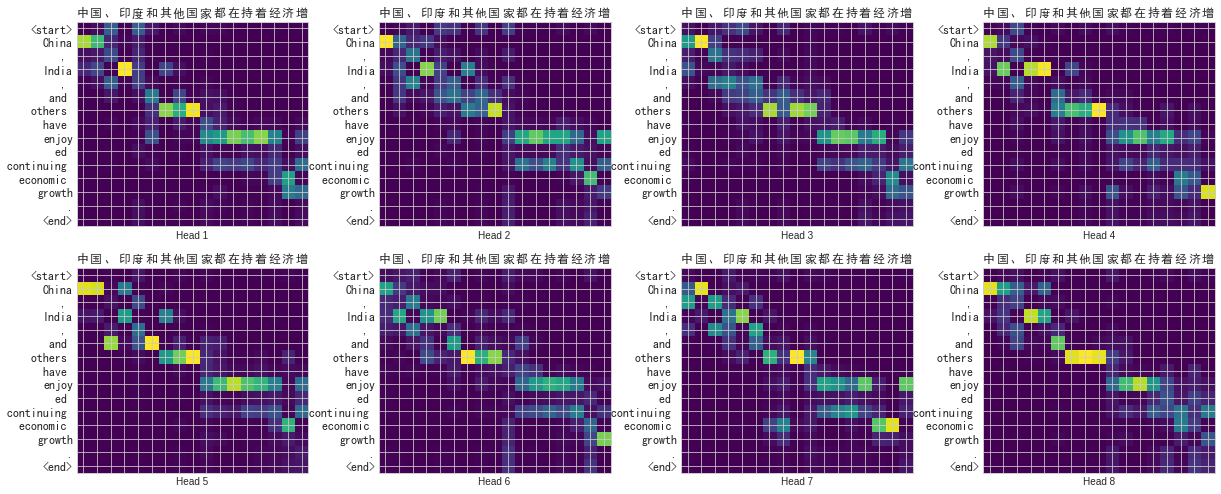

In [0]:
plot_attention_weights(attention_weights, sentence,predicted_seq, layer_name, max_len_tar=18)